In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

### Step 1: Importing necessary libraries

In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# wandb library
import wandb

#### Setting up directory for the files

In [3]:
import os
from pathlib import Path

# Set the working directory to the given location
os.chdir(r'/Users/anxiousviking/Documents/course/Sem 3/NLP/lect 5/assignment')

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Define the base path
basepath = r'/Users/anxiousviking/Documents/course/Sem 3/NLP/lect 5/assignment'

# Create the data folder, model folder, and custom functions folder
data_folder = Path(basepath) / 'data_folder/'
model_folder = Path(basepath) / 'sentiment' / 'nn'
custom_functions = Path(basepath) / 'CustomFiles'

# Create the necessary directories if they don't exist
model_folder.mkdir(exist_ok=True, parents=True)
custom_functions.mkdir(exist_ok=True, parents=True)

# Verify that the folders are created
print(f"Model folder created: {model_folder.exists()}")
print(f"Custom functions folder created: {custom_functions.exists()}")

Current working directory: /Users/anxiousviking/Documents/course/Sem 3/NLP/lect 5/assignment
Model folder created: True
Custom functions folder created: True


### Step 2: Load Data and preprocessing

In [4]:
# Read in the Training and Testing Dataset

train_df = pd.read_csv(data_folder/'train.csv')
valid_df = pd.read_csv(data_folder/'test.csv')

In [5]:
train_df.head(3)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0


In [6]:
from pprint import pprint
pprint(train_df['Tweet'].values[1], width=80)
pprint(train_df['Tweet'].values[10], width=80)
pprint(train_df['Tweet'].values[50], width=80)

'Whatever you decide to do make sure it makes you #happy.'
('Making that yearly transition from excited and hopeful college returner to '
 'sick and exhausted pessimist. #college')
('@BigLepley @angela31694996 @TheIndigoArrow Want to start a biker gang '
 'together when the GTA Online Biker DLC comes out?')


In [7]:
train_df.shape

(7724, 13)

In [8]:
valid_df.shape

(3259, 13)

#### Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Split train_df into train_set (80%) and test_set (20%)
train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=1)

#### Data PreProcessing

In [10]:
# !python -m spacy download en_core_web_sm

In [11]:
# Load the model -en_core_web_sm
import spacy

nlp = spacy.load('en_core_web_sm')

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from bs4 import BeautifulSoup
import re
import spacy
import numpy as np
from nltk.stem.porter import PorterStemmer
import os

class SpacyPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, model, *, batch_size=64, lemmatize=True, lower=True, remove_stop=True,
                 remove_punct=True, remove_email=True, remove_url=True, remove_num=False, stemming=False,
                 add_user_mention_prefix=False, remove_hashtag_prefix=False, basic_clean_only=False):
        """
        Initialize the preprocessor with options for token processing.
        - Set add_user_mention_prefix=False to remove @mentions.
        - Set remove_hashtag_prefix=False to keep #hashtags.
        """
        self.model = model
        self.batch_size = batch_size
        self.remove_stop = remove_stop
        self.remove_punct = remove_punct
        self.remove_num = remove_num
        self.remove_url = remove_url
        self.remove_email = remove_email
        self.lower = lower
        self.add_user_mention_prefix = add_user_mention_prefix
        self.remove_hashtag_prefix = remove_hashtag_prefix
        self.basic_clean_only = basic_clean_only

        if lemmatize and stemming:
            raise ValueError("Only one of 'lemmatize' and 'stemming' can be True.")

        # Validate basic_clean_only option
        if self.basic_clean_only and (lemmatize or lower or remove_stop or remove_punct or remove_num or stemming or
                                      add_user_mention_prefix or remove_hashtag_prefix):
            raise ValueError("If 'basic_clean_only' is set to True, other processing options must be set to False.")

        # Assign lemmatize and stemming
        self.lemmatize = lemmatize
        self.stemming = stemming

    def basic_clean(self, text):
        # Check if the text looks like a file path and skip BeautifulSoup if it does
        if os.path.isfile(text):
            return text  # If it's a file path, return as is
        # Otherwise, clean normally using BeautifulSoup
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()  # Extract text without markup
        text = re.sub(r'[\n\r]', ' ', text)  # Remove newline characters
        return text.strip()

    def get_cores(self):
        """
        Get the number of CPU cores to use in parallel processing.
        """
        num_cores = os.cpu_count()
        if num_cores < 3:
            use_cores = 1
        else:
            use_cores = num_cores // 2 + 1
        return use_cores

    def spacy_preprocessor(self, texts):
        final_result = []
        nlp = spacy.load(self.model)

        # Disable unnecessary pipelines in spaCy model
        if self.lemmatize:
            disabled_pipes = ['parser', 'ner']
        else:
            disabled_pipes = ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

        with nlp.select_pipes(disable=disabled_pipes):
            # Modify tokenizer behavior based on hashtag settings
            if self.remove_hashtag_prefix:
                prefixes = list(nlp.Defaults.prefixes)
                prefixes.remove(r'#')  # Keep the hashtag symbol as part of the token
                prefix_regex = spacy.util.compile_prefix_regex(prefixes)
                nlp.tokenizer.prefix_search = prefix_regex.search

            # Process text data in parallel using spaCy's nlp.pipe()
            for doc in nlp.pipe(texts, batch_size=self.batch_size, n_process=self.get_cores()):
                filtered_tokens = []
                for token in doc:
                    # Check if token should be removed based on specified filters
                    if self.remove_stop and token.is_stop:
                        continue
                    if self.remove_punct and token.is_punct:
                        continue
                    if self.remove_num and token.like_num:
                        continue
                    if self.remove_url and token.like_url:
                        continue
                    if self.remove_email and token.like_email:
                        continue
                    if token.text.startswith('@'):  # Remove @mentions
                        continue

                    # Append the token's text, lemma, or stemmed form to the filtered_tokens list
                    if self.lemmatize:
                        filtered_tokens.append(token.lemma_)
                    elif self.stemming:
                        filtered_tokens.append(PorterStemmer().stem(token.text))
                    else:
                        filtered_tokens.append(token.text)

                # Join the tokens and apply lowercasing if specified
                text = ' '.join(filtered_tokens)
                if self.lower:
                    text = text.lower()
                final_result.append(text.strip())

        return final_result

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        try:
            if not isinstance(X, (list, np.ndarray)):
                raise TypeError(f'Expected list or numpy array, got {type(X)}')

            x_clean = [self.basic_clean(text).encode('utf-8', 'ignore').decode() for text in X]

            # Check if only basic cleaning is required
            if self.basic_clean_only:
                return x_clean  # Return the list of basic-cleaned texts

            x_clean_final = self.spacy_preprocessor(x_clean)
            return x_clean_final

        except Exception as error:
            print(f'An exception occurred: {repr(error)}')


#### Modifying spacy to remove @ and keep # as they might add value to the emotions in tweets

In [13]:
# Initialize the SpacyPreprocessor. We are going to remove @ and keep the #
preprocessor = SpacyPreprocessor(
    model='en_core_web_sm',
    lemmatize=True,
    lower=True,
    remove_stop=True,
    remove_punct=True,
    remove_email=True,
    remove_url=True,
    remove_num=False,
    stemming=False,
    add_user_mention_prefix=False,  # Remove @mentions
    remove_hashtag_prefix=False     # Keep #hashtags
)

In [14]:
# Apply preprocessing to the train_set (fit and transform)
train_set['Cleaned_Reviews'] = preprocessor.fit_transform(train_set['Tweet'].values)

/var/folders/9q/vqgvcv992rb1j75lkp2l_80h0000gn/T/ipykernel_14549/3860166522.py:48: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [15]:
train_set.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,Cleaned_Reviews
3916,2017-41313,@chrislhayes It's hard for most folks to reali...,1,0,1,0,0,0,0,0,0,0,0,hard folk realize deep hatred dive murky end p...
3696,2017-30339,@PersephoneOD Her cheerful voice echoed throug...,0,0,0,0,1,1,1,0,0,0,0,cheerful voice echo grand familiar home smile ...
4067,2017-10126,@brian5or6 turn that shit off! Home Button u...,1,0,1,0,0,0,0,0,0,0,0,turn shit home button accessibility \n\nwhe...
3665,2017-21523,#smackdev #ptp #start oh yeah!,0,0,0,0,1,0,1,0,0,0,0,smackdev ptp start oh yeah
7626,2018-02014,"It could be soul-crushing despair, but it also...",0,0,0,0,0,0,0,0,1,0,0,soul crush despair marshmallow breakfast


In [16]:
pprint(train_set['Tweet'].values[100], width=80)

('Very long day. Thank goodness for Bake Off to brighten up a weary Wednesday '
 '☺ #GBBO')


In [17]:
pprint(train_set['Cleaned_Reviews'].values[100], width=80)

'long day thank goodness bake brighten weary wednesday ☺ gbbo'


In [18]:
# Apply preprocessing to the test_set and validation_df (transform only)
test_set['Cleaned_Reviews'] = preprocessor.transform(test_set['Tweet'].values)
valid_df['Cleaned_Reviews'] = preprocessor.transform(valid_df['Tweet'].values)

/var/folders/9q/vqgvcv992rb1j75lkp2l_80h0000gn/T/ipykernel_14549/3860166522.py:48: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/var/folders/9q/vqgvcv992rb1j75lkp2l_80h0000gn/T/ipykernel_14549/3860166522.py:48: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [19]:
pprint(valid_df['Cleaned_Reviews'].values[0], width=80)

'not worry indian army way dispatch terrorists hell'


### Step 3: working with HuggingFace Dataset

In [20]:
import pandas as pd
from datasets import Dataset

def convert_to_hf_dataset(df, text_column='Cleaned_Reviews', label_columns=None):
    """
    Converts a pandas DataFrame to a Hugging Face Dataset for multi-label classification.
    
    Args:
    df (pd.DataFrame): The input pandas DataFrame.
    text_column (str): The name of the column containing the text data (default is 'Cleaned_Reviews').
    label_columns (list): List of column names that contain the sentiment labels.
    
    Returns:
    hf_dataset (datasets.Dataset): A Hugging Face Dataset ready for multi-label classification.
    """
    # Ensure label_columns is provided
    if label_columns is None:
        raise ValueError("label_columns must be a list of the sentiment label columns.")

    # Remove unnecessary columns (in case 'ID' or 'Tweet' exist)
    # Keeping only the text_column and the label_columns
    df = df[[text_column] + label_columns]
    
    # Ensure labels are cast to integers
    df[label_columns] = df[label_columns].astype(int)
    
    # Convert DataFrame to Hugging Face Dataset
    hf_dataset = Dataset.from_pandas(df)
    
    # Define a preprocessing function to convert label columns to a list of labels
    def preprocess_data(examples):
        # Create a 'labels' list from the label columns for multi-label classification
        examples['labels'] = [examples[col] for col in label_columns]
        return examples

    # Apply preprocessing to create the 'labels' column
    hf_dataset = hf_dataset.map(preprocess_data)

    # Remove the individual sentiment label columns to avoid duplication
    hf_dataset = hf_dataset.remove_columns(label_columns)

    return hf_dataset


In [21]:
train_set.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust',
       'Cleaned_Reviews'],
      dtype='object')

In [22]:
# Defining the label columns (the multi-label sentiment categories)
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 
                 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']


# Convert train_set DataFrame to a Hugging Face Dataset
hf_train_set = convert_to_hf_dataset(train_set,
                                   text_column='Cleaned_Reviews',
                                   label_columns=label_columns)


# Convert Test_set DataFrame to a Hugging Face Dataset
hf_test_set = convert_to_hf_dataset(test_set,
                                    text_column='Cleaned_Reviews',
                                    label_columns=label_columns)

/var/folders/9q/vqgvcv992rb1j75lkp2l_80h0000gn/T/ipykernel_14549/1091016352.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_columns] = df[label_columns].astype(int)


Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

/var/folders/9q/vqgvcv992rb1j75lkp2l_80h0000gn/T/ipykernel_14549/1091016352.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_columns] = df[label_columns].astype(int)


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [23]:
print(hf_train_set[0])

{'Cleaned_Reviews': 'hard folk realize deep hatred dive murky end pool guy nuts', '__index_level_0__': 3916, 'labels': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]}


In [24]:
hf_train_set

Dataset({
    features: ['Cleaned_Reviews', '__index_level_0__', 'labels'],
    num_rows: 6179
})

In [25]:
hf_test_set

Dataset({
    features: ['Cleaned_Reviews', '__index_level_0__', 'labels'],
    num_rows: 1545
})

In [26]:
hf_train_set.features

{'Cleaned_Reviews': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [27]:
hf_train_set = hf_train_set.remove_columns(['__index_level_0__'])
hf_train_set.features

{'Cleaned_Reviews': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [28]:
hf_test_set = hf_test_set.remove_columns(['__index_level_0__'])
hf_test_set.features

{'Cleaned_Reviews': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [29]:
hf_train_set[0]['Cleaned_Reviews']

'hard folk realize deep hatred dive murky end pool guy nuts'

In [30]:
# Converting the Validation set to Hugging Face Dataset.
# Only keep the 'Tweet' column (since we are predicting and don’t have labels)
valid_df = valid_df[['Cleaned_Reviews']]

# Convert the DataFrame to a Hugging Face Dataset
hf_valid_dataset = Dataset.from_pandas(valid_df)

# Check the dataset
print(hf_valid_dataset[0])

{'Cleaned_Reviews': 'not worry indian army way dispatch terrorists hell'}


In [31]:
print(hf_train_set[100])  # Check the structure of the first training sample
print(hf_test_set[100])   # Check the structure of the first test sample



{'Cleaned_Reviews': 'long day thank goodness bake brighten weary wednesday ☺ gbbo', 'labels': [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]}
{'Cleaned_Reviews': 'mom work discount riot f ticket $ 147/3 day sadden', 'labels': [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]}


### Step 4: Creating the Vocab

In [32]:
from collections import Counter, OrderedDict
from typing import Dict, List, Optional, Union

class Vocab:
    def __init__(self, tokens: List[str]) -> None:
        self.itos: List[str] = tokens  # List of tokens (indices to strings)
        self.stoi: Dict[str, int] = {token: i for i, token in enumerate(tokens)}  # Map tokens to indices
        self.default_index: Optional[int] = None  # Index for unknown tokens

    def __getitem__(self, token: str) -> int:
        # Return the index of the token, or the default index if it's unknown
        if token in self.stoi:
            return self.stoi[token]
        if self.default_index is not None:
            return self.default_index
        raise RuntimeError(f"Token '{token}' not found in vocab")

    def __len__(self) -> int:
        return len(self.itos)

    def insert_token(self, token: str, index: int) -> None:
        # Insert token at a specific index in the vocab
        if index < 0 or index > len(self.itos):
            raise ValueError("Index out of range")
        if token in self.stoi:
            old_index = self.stoi[token]
            self.itos.pop(old_index)
            self.itos.insert(index, token)
        else:
            self.itos.insert(index, token)
        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def append_token(self, token: str) -> None:
        # Append a token to the vocab
        if token in self.stoi:
            raise RuntimeError(f"Token '{token}' already exists in the vocab")
        self.insert_token(token, len(self.itos))

    def set_default_index(self, index: Optional[int]) -> None:
        self.default_index = index

    def get_default_index(self) -> Optional[int]:
        return self.default_index

    def lookup_token(self, index: int) -> str:
        # Return the token given its index
        if 0 <= index < len(self.itos):
            return self.itos[index]
        raise RuntimeError(f"Index {index} out of range")

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        # Return a list of tokens given a list of indices
        return [self.lookup_token(index) for index in indices]

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        # Return a list of indices given a list of tokens
        return [self[token] for token in tokens]

    def get_stoi(self) -> Dict[str, int]:
        return self.stoi.copy()

    def get_itos(self) -> List[str]:
        return self.itos.copy()

    @classmethod
    def vocab(cls, ordered_dict: Union[OrderedDict, Counter], min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True) -> 'Vocab':
        specials = specials or []
        for token in specials:
            ordered_dict.pop(token, None)
        tokens = [token for token, freq in ordered_dict.items() if freq >= min_freq]
        if special_first:
            tokens = specials + tokens
        else:
            tokens = tokens + specials
        return cls(tokens)


In [33]:
# Function to create a vocabulary from the dataset
def get_vocab(dataset, min_freq=1):
    counter = Counter()
    
    # Count frequencies of tokens in the dataset
    for text in dataset['Cleaned_Reviews']:  # Assuming 'Cleaned_Reviews' is the preprocessed text column
        counter.update(str(text).split())

    # Create vocabulary using the Counter object
    my_vocab = Vocab.vocab(counter, min_freq=min_freq)
    
    # Insert the unknown token <unk> at index 0
    my_vocab.insert_token('<unk>', 0)
    
    # Set the default index to 0 (for unknown tokens)
    my_vocab.set_default_index(0)
    
    return my_vocab

# Create the vocabulary using the trainset
emotion_vocab = get_vocab(train_set, min_freq=2)


### Step 5: Defining Custom Model and Model Config Class

In [34]:
from transformers import PretrainedConfig

# CustomConfig class to define model-specific hyperparameters
class CustomConfig(PretrainedConfig):
    def __init__(self, vocab_size=0, embedding_dim=0, hidden_dim1=0, hidden_dim2=0, num_labels=2, **kwargs):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.num_labels = num_labels

In [35]:
import torch.nn as nn
from transformers import PreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput

# CustomMLP class for the multi-layer perceptron model
class CustomMLP(PreTrainedModel):
    config_class = CustomConfig

    def __init__(self, config):
        super().__init__(config)

        # EmbeddingBag layer to handle text embeddings
        self.embedding_bag = nn.EmbeddingBag(config.vocab_size, config.embedding_dim)

        # Sequential model containing multiple layers
        self.layers = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim1),
            nn.BatchNorm1d(num_features=config.hidden_dim1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim1, config.hidden_dim2),
            nn.BatchNorm1d(num_features=config.hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim2, config.num_labels)  # Output layer with logits for each emotion label
        )

    def forward(self, input_ids, offsets, labels=None):
        # Get embeddings from input tokens
        embed_out = self.embedding_bag(input_ids, offsets)

        # Pass through the layers to get logits
        logits = self.layers(embed_out)

        # Calculate loss if labels are provided (for training)
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy for multi-label classification
            loss = loss_fct(logits, labels.float())  # Convert labels to float

        # Return loss and logits
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )


#### Collate Function

In [36]:
# Tokenizer function to convert text into a list of token indices based on the vocabulary
def tokenizer(text, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(text).split()]  # Split text into tokens and map each to an index


In [37]:
import torch

def collate_batch(batch, my_vocab):
    """
    Prepares a batch of data by transforming texts into indices based on a vocabulary and
    converting labels into a tensor.

    Args:
        batch (list of dict): A batch of data where each element is a dictionary with keys
                              'labels' and 'Cleaned_Reviews'. 'labels' are the emotion labels,
                              and 'Cleaned_Reviews' are the corresponding texts (tweets).
        my_vocab (Vocab): The vocabulary object that maps tokens to indices.

    Returns:
        dict: A dictionary with three keys:
              - 'input_ids': A tensor containing concatenated indices of the texts.
              - 'offsets': A tensor representing the starting index of each text in 'input_ids'.
              - 'labels': A tensor of the labels for each text in the batch.
    """

    # Extract labels and texts from the batch
    labels = [sample['labels'] for sample in batch]  # Multi-labels (binary vectors for emotions)
    texts = [sample['Cleaned_Reviews'] for sample in batch]  # Texts (tweets)

    # Convert the list of labels into a tensor (dtype float32 for multi-label classification)
    labels = torch.tensor(labels, dtype=torch.float32)

    # Convert the list of texts into a list of token indices using the tokenizer
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all token indices into a single tensor (input_ids)
    input_ids = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return {
        'input_ids': input_ids,  # Flattened input tokens
        'offsets': offsets,  # Offsets to keep track of the start of each tweet
        'labels': labels  # Multi-labels (emotion binary vectors)
    }


In [38]:
collate_fn = partial(collate_batch, my_vocab=emotion_vocab)
# processed_batch = collate_fn(batch)

#### Instantiate Model

In [39]:
# Instantiate the configuration after the vocabulary is created
my_config = CustomConfig(
    vocab_size=len(emotion_vocab),  # Use the size of the vocabulary generated above
    embedding_dim=300,  # Embedding dimension
    hidden_dim1=200,  # First hidden layer size
    hidden_dim2=100,  # Second hidden layer size
    num_labels=11  # Number of emotion labels
)

# Map label indices to emotion classes
my_config.id2label = {
    0: 'anger', 1: 'anticipation', 2: 'disgust', 3: 'fear', 4: 'joy', 
    5: 'love', 6: 'optimism', 7: 'pessimism', 8: 'sadness', 9: 'surprise', 10: 'trust'
}

# Reverse the mapping to create label2id
my_config.label2id = {v: k for k, v in my_config.id2label.items()}


In [40]:
my_config

CustomConfig {
  "embedding_dim": 300,
  "hidden_dim1": 200,
  "hidden_dim2": 100,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "transformers_version": "4.45.1",
  "vocab_size": 4980
}

In [41]:
# Instantiate the model using the configuration
model = CustomMLP(config=my_config)

# Print the model architecture to check everything is set up correctly
print(model)

CustomMLP(
  (embedding_bag): EmbeddingBag(4980, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=11, bias=True)
  )
)


### Step 6: Compute_Metrics Function

In [42]:
import numpy as np
import evaluate
import torch

# Define the compute_metrics function
def compute_metrics(eval_pred):
    # Unpack predictions and labels
    logits, labels = eval_pred

    # Apply sigmoid to logits for multi-label classification (to get probabilities)
    sigmoid_logits = torch.sigmoid(torch.tensor(logits))

    # Convert logits to predictions (1 if > 0.5, else 0)
    predictions = (sigmoid_logits > 0.5).int()

    # Convert labels to int if they are in float
    labels = torch.tensor(labels).int()

    # Flatten both predictions and labels for metric calculation
    predictions = predictions.view(-1).cpu().numpy()
    labels = labels.view(-1).cpu().numpy()

    # Load evaluation metrics
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1", average="macro")  # Macro F1-score for multi-label classification

    # Compute the accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    # Compute the F1-score
    f1_score = f1_metric.compute(predictions=predictions, references=labels)

    # Return both accuracy and F1 score
    return {
        "accuracy": accuracy["accuracy"],
        "f1_score": f1_score["f1"]
    }


### Step 7: Training Arguments

In [43]:
from transformers import TrainingArguments

# Configure training parameters for the Emotion Detection task
training_args = TrainingArguments(

    # Training-specific configurations
    num_train_epochs=5,  # Number of epochs
    per_device_train_batch_size=64,  # Batch size for training
    per_device_eval_batch_size=64,  # Batch size for evaluation
    weight_decay=0.1,  # L2 regularization
    learning_rate=0.001,  # Learning rate
    optim='adamw_torch',  # Optimizer
    remove_unused_columns=False,  # Keep all columns in the dataset

    # Checkpoint saving and model evaluation settings
    output_dir="./emotion_results",  # Directory to save checkpoints and outputs
    eval_strategy='steps',  # Use `eval_strategy` instead of `evaluation_strategy`
    eval_steps=100,  # Perform evaluation every 100 training steps
    save_strategy="steps",  # Save model checkpoints periodically
    save_steps=100,  # Save a model checkpoint every 100 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=3,  # Retain only the best 3 models

    # Evaluation and model comparison settings
    metric_for_best_model="f1_score",  # Use F1 score as the metric for the best model
    greater_is_better=True,  # A higher F1 score is better

    # Experiment logging configurations
    logging_strategy='steps',  # Log metrics and loss periodically during training
    logging_steps=50,  # Log every 50 training steps
    report_to='wandb',  # Use Weights & Biases for logging
    run_name='emotion_detection_trainer',  # Name of the experiment for Weights & Biases
)


Explanation of Each Argument:
`num_train_epochs=5`:
Explanation: Number of times the model sees the entire training dataset.
Tweaks: Increase or decrease depending on dataset size and model performance. More epochs for smaller datasets, fewer epochs for larger datasets.


`per_device_train_batch_size=64`:
Explanation: Number of samples per batch during training.
Tweaks: Adjust based on your GPU/CPU memory. A smaller batch size may be needed for limited resources, while larger batch sizes can speed up training on powerful hardware.

`per_device_eval_batch_size=64`:
Explanation: Batch size for evaluation.
Tweaks: Usually matches the training batch size but can be smaller if memory is an issue.


`weight_decay=0.1`:
Explanation: Weight decay (L2 regularization) to prevent overfitting by penalizing large weights.
Tweaks: You can lower this if you think overfitting is not an issue or increase it if overfitting persists.


`learning_rate=0.001`:
Explanation: The step size for updating model weights during training.
Tweaks: Use a smaller learning rate (e.g., 0.0001) if the model isn’t converging or is unstable. A larger learning rate (e.g., 0.01) can speed up training, but it may cause the model to miss the optimal point.


`optim='adamw_torch'`:
Explanation: The optimizer to use. adamw_torch is an AdamW optimizer designed for training transformers, which applies weight decay correctly.
Tweaks: You can use different optimizers like adam or sgd for experimentation.


`remove_unused_columns=False`:
Explanation: Retain all columns in the dataset (even if the model doesn’t use them). This ensures that no relevant data is dropped.
Tweaks: If your dataset has unnecessary columns that you don’t need, you can set this to True to remove them and optimize memory usage.


`output_dir="./emotion_results"`:
Explanation: Directory to store checkpoints, logs, and other outputs.
Tweaks: Change this path if you want to save results in a different location.


`evaluation_strategy='steps'`:
Explanation: Perform evaluations during training at regular step intervals.
Options: You can use 'epoch' to evaluate at the end of every epoch instead of after a specific number of steps.


`eval_steps=100`:
Explanation: Evaluate the model every 100 training steps.
Tweaks: Increase this number to evaluate less frequently or decrease it for more frequent evaluations.


`save_strategy="steps"`:
Explanation: Save model checkpoints periodically during training.
Tweaks: You can change this to 'epoch' to save checkpoints after every epoch instead of steps.


`save_steps=100`:
Explanation: Save a checkpoint every 100 training steps.
Tweaks: Increase this number to save less frequently or decrease it to save more often.


`load_best_model_at_end=True`:
Explanation: At the end of training, reload the best model (based on evaluation metrics).
Tweaks: Set to False if you don’t want to load the best model at the end (for experimentation purposes).


`save_total_limit=3`:
Explanation: Keep only the best 3 model checkpoints (older ones are deleted).
Tweaks: Increase this if you want to retain more model checkpoints or set it lower if you want to conserve disk space.


`metric_for_best_model="f1_score"`:
Explanation: Use the F1 score to determine the best model during evaluation.
Tweaks: You could also use "accuracy", "precision", or "recall" depending on what metric is most important for your problem.


`greater_is_better=True`:
Explanation: A model is considered better if its evaluation metric (F1 score in this case) is higher.
Tweaks: Set to False if you're optimizing for a metric where lower values are better (e.g., loss).


`logging_strategy='steps'`:
Explanation: Log training metrics and loss at regular intervals.
Tweaks: You can change this to 'epoch' if you prefer logging at the end of each epoch instead of steps.


`logging_steps=50`:
Explanation: Log metrics every 50 steps.
Tweaks: Increase this number to log less frequently or decrease it to log more often.

`report_to='wandb'`:
Explanation: Log results to Weights & Biases (WandB), a platform for tracking experiments and visualizing training metrics.
Tweaks: Change this to 'tensorboard' to log to TensorBoard or ['wandb', 'tensorboard'] to log to both platforms.


`run_name='emotion_detection_trainer':`
Explanation: Name of the experiment in Weights & Biases (or TensorBoard if using that).
Tweaks: You can modify this to track different experiments under different names.

In [44]:
## Initialize Trainer
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,  # The model we instantiated (CustomMLP)
    args=training_args,  # The training arguments we just defined
    train_dataset=hf_train_set,  # The training dataset (ensure it's preprocessed)
    eval_dataset=hf_test_set,  # The validation dataset for evaluation during training
    data_collator=collate_fn,  # Function to collate batches (defined earlier)
    compute_metrics=compute_metrics  # Function to compute metrics (defined earlier)
)

#### Setup Weight and Bias

In [45]:
import wandb

# Log into WandB
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shobhit-pachauri (shobhit-pachauri-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


True

In [46]:
import os

# Set the WandB project name (adjust for your task)
os.environ["WANDB_PROJECT"] = "emotion_detection_fall_2024"

### Step 7: Training and Validation

In [47]:
# Start training and log to WandB
trainer.train()

  0%|          | 0/485 [00:00<?, ?it/s]

/Users/anxiousviking/anaconda3/lib/python3.11/site-packages/torch/nn/functional.py:2454: UserWarning: The operator 'aten::_embedding_bag' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret, _, _, _ = torch.embedding_bag(


{'loss': 0.5786, 'grad_norm': 0.41275927424430847, 'learning_rate': 0.0008969072164948454, 'epoch': 0.52}
{'loss': 0.4792, 'grad_norm': 0.34389716386795044, 'learning_rate': 0.0007938144329896907, 'epoch': 1.03}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4743071496486664, 'eval_accuracy': 0.8017063842306561, 'eval_f1_score': 0.20817669172932332, 'eval_runtime': 1.7214, 'eval_samples_per_second': 897.521, 'eval_steps_per_second': 14.523, 'epoch': 1.03}
{'loss': 0.4518, 'grad_norm': 0.43890172243118286, 'learning_rate': 0.0006907216494845361, 'epoch': 1.55}
{'loss': 0.4398, 'grad_norm': 0.31988656520843506, 'learning_rate': 0.0005876288659793815, 'epoch': 2.06}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.43767857551574707, 'eval_accuracy': 0.81306266548985, 'eval_f1_score': 0.35805213174378664, 'eval_runtime': 1.5415, 'eval_samples_per_second': 1002.283, 'eval_steps_per_second': 16.218, 'epoch': 2.06}
{'loss': 0.4203, 'grad_norm': 0.33897170424461365, 'learning_rate': 0.0004845360824742268, 'epoch': 2.58}
{'loss': 0.4085, 'grad_norm': 0.30443075299263, 'learning_rate': 0.00038144329896907213, 'epoch': 3.09}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4220632314682007, 'eval_accuracy': 0.8200647249190939, 'eval_f1_score': 0.4362094395280236, 'eval_runtime': 1.4102, 'eval_samples_per_second': 1095.563, 'eval_steps_per_second': 17.728, 'epoch': 3.09}
{'loss': 0.4004, 'grad_norm': 0.3677012026309967, 'learning_rate': 0.00027835051546391755, 'epoch': 3.61}
{'loss': 0.3946, 'grad_norm': 0.38723546266555786, 'learning_rate': 0.00017525773195876287, 'epoch': 4.12}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.409931480884552, 'eval_accuracy': 0.8224183583406884, 'eval_f1_score': 0.45680345572354214, 'eval_runtime': 1.3766, 'eval_samples_per_second': 1122.295, 'eval_steps_per_second': 18.16, 'epoch': 4.12}
{'loss': 0.3935, 'grad_norm': 0.4994026720523834, 'learning_rate': 7.216494845360824e-05, 'epoch': 4.64}
{'train_runtime': 15.8481, 'train_samples_per_second': 1949.45, 'train_steps_per_second': 30.603, 'train_loss': 0.4369899631775532, 'epoch': 5.0}


TrainOutput(global_step=485, training_loss=0.4369899631775532, metrics={'train_runtime': 15.8481, 'train_samples_per_second': 1949.45, 'train_steps_per_second': 30.603, 'total_flos': 2361936165480.0, 'train_loss': 0.4369899631775532, 'epoch': 5.0})

In [48]:
trainer.evaluate()

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.409931480884552,
 'eval_accuracy': 0.8224183583406884,
 'eval_f1_score': 0.45680345572354214,
 'eval_runtime': 1.411,
 'eval_samples_per_second': 1094.952,
 'eval_steps_per_second': 17.718,
 'epoch': 5.0}

### Step 8: Confusion Matrix

In [49]:
# Predict using the validation set
valid_output = trainer.predict(hf_test_set)  # Replace 'validset' with the actual valid dataset variable

  0%|          | 0/25 [00:00<?, ?it/s]

In [50]:
print(valid_output._fields)

('predictions', 'label_ids', 'metrics')


In [51]:
# For multi-label classification, use sigmoid and threshold the predictions
valid_preds = (torch.sigmoid(torch.tensor(valid_output.predictions)) > 0.5).int().numpy()

# Extract the actual labels (if available)
valid_labels = np.array(valid_output.label_ids)  # Only if ground truth labels are available

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots confusion matrices for each emotion (multi-label classification).
    
    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels (from `my_config.id2label.values()`).
    """
    # Compute the confusion matrix for each label
    confusion_matrices = multilabel_confusion_matrix(valid_labels, valid_preds)
    
    # Plot confusion matrix for each class
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # Adjust based on the number of labels (11 classes)
    axes = axes.flatten()

    for i, cm in enumerate(confusion_matrices):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {class_labels[i]}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


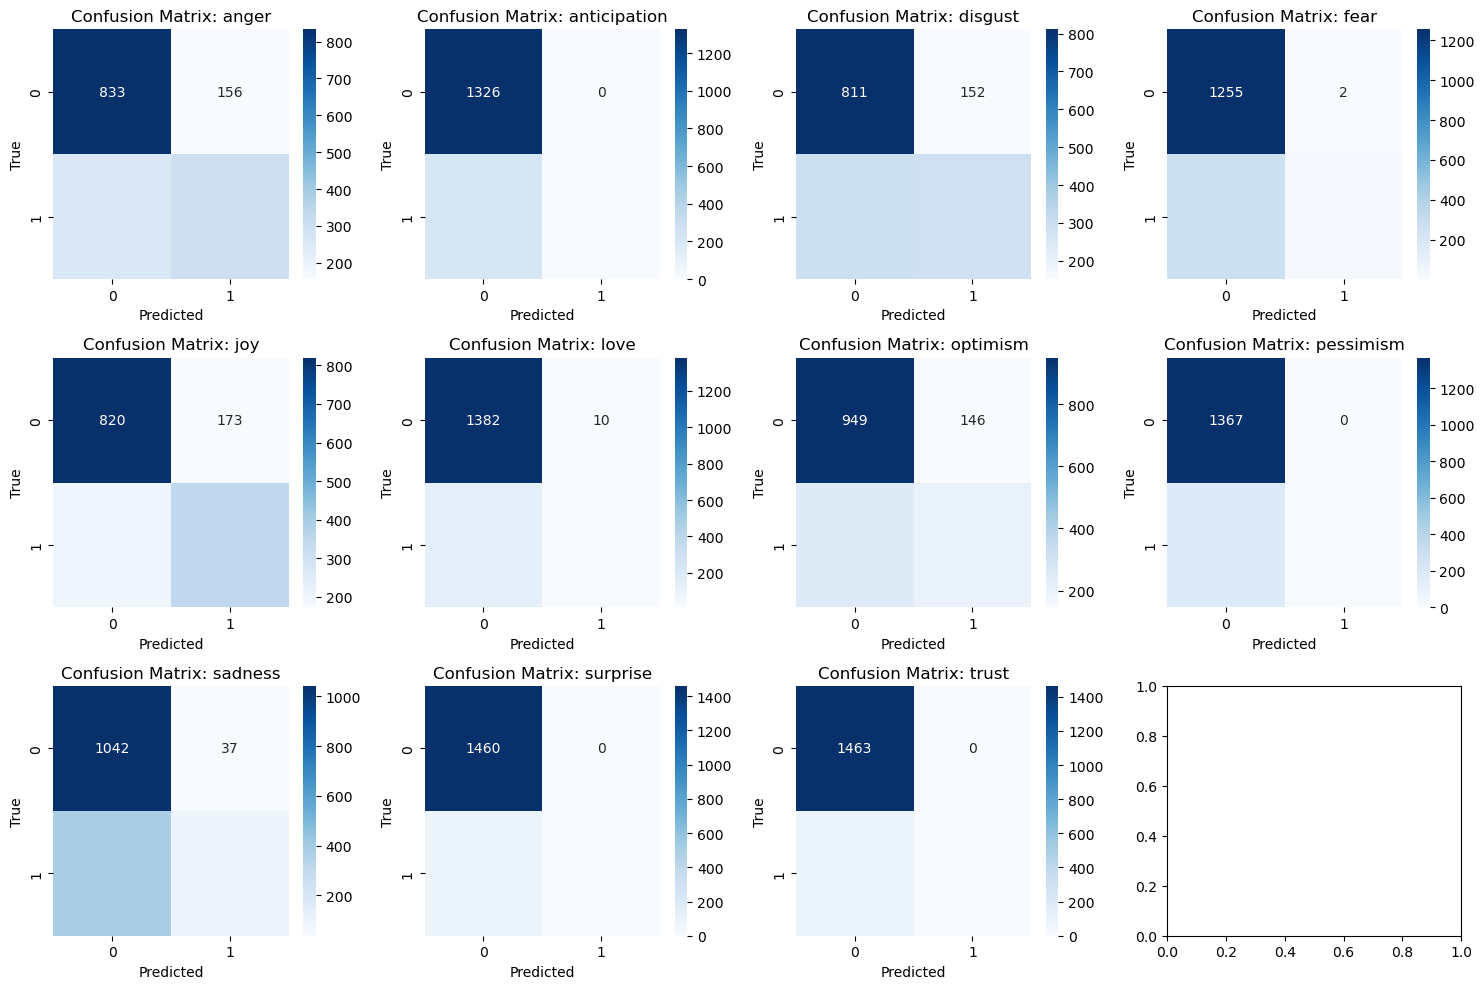

In [53]:
# Use class labels from my_config.id2label
plot_confusion_matrix(valid_labels,
                      valid_preds,
                      class_labels=list(my_config.id2label.values()))

In [54]:
# Import necessary libraries
import wandb
import numpy as np
from sklearn.metrics import confusion_matrix

# Log each confusion matrix separately for multi-label classification
for i, class_name in enumerate(list(my_config.id2label.values())):
    cm = confusion_matrix(valid_labels[:, i], valid_preds[:, i])  # Confusion matrix for each label
    cm_plot = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues").get_figure()

    # Log the confusion matrix plot to WandB for each class
    wandb.log({f"conf_matrix_{class_name}": wandb.Image(cm_plot)})
    
    # Close the figure to avoid overlap
    plt.close(cm_plot)


#### Best CheckPoint

In [55]:
# Check the best checkpoint saved during training
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 400.


In [56]:
wandb.finish()

eval/accuracy,▁▅▇██
eval/f1_score,▁▅▇██
eval/loss,█▄▂▁▁
eval/runtime,█▄▂▁▂
eval/samples_per_second,▁▄▇█▇
eval/steps_per_second,▁▄▇█▇
test/accuracy,▁
test/f1_score,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁


### Step 9: Performance on the Test Set

#### Load Model From Checkpoint

In [57]:
from pathlib import Path
import torch

# Define the base path and checkpoint folder in emotion_results
emotion_results_folder = Path(basepath) / 'emotion_results'

# Assuming the best checkpoint step is 400 (adjust if needed)
best_model_checkpoint_step = 400

# Define the path to the best model checkpoint inside the emotion_results folder
model_checkpoint = emotion_results_folder / f'checkpoint-{best_model_checkpoint_step}'

# Check if the checkpoint folder exists
if not model_checkpoint.exists():
    raise FileNotFoundError(f"Checkpoint directory does not exist: {model_checkpoint}")

# Convert to string if required (since 'from_pretrained()' expects a string path)
model_checkpoint = str(model_checkpoint)

# Instantiate the CustomMLP model with predefined configurations
model = CustomMLP(my_config)

# Use from_pretrained() to load the weights from the specified checkpoint directory
model = model.from_pretrained(model_checkpoint, config=my_config, local_files_only=True)

# Move the model to the appropriate device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Put the model in evaluation mode
model.eval()

# Display the loaded model
print("Model loaded successfully!")
print(model)


Model loaded successfully!
CustomMLP(
  (embedding_bag): EmbeddingBag(4980, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=11, bias=True)
  )
)


#### Instantiate Trainer for Evaluation

In [58]:
import torch

def collate_batch(batch, my_vocab):
    """
    Prepares a batch of data by transforming texts into indices based on a vocabulary and
    converting labels into a tensor (if labels exist).

    Args:
        batch (list of dict): A batch of data where each element is a dictionary with keys
                              'labels' (if available) and 'Cleaned_Reviews' (the tweets).
        my_vocab (Vocab): The vocabulary object that maps tokens to indices.

    Returns:
        dict: A dictionary with two or three keys:
              - 'input_ids': A tensor containing concatenated indices of the texts.
              - 'offsets': A tensor representing the starting index of each text in 'input_ids'.
              - 'labels': A tensor of the labels for each text in the batch (if available).
    """

    # Extract texts (tweets) from the batch
    texts = [sample['Cleaned_Reviews'] for sample in batch]  # Texts (tweets)

    # Convert the list of texts into a list of token indices using the tokenizer
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all token indices into a single tensor (input_ids)
    input_ids = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Check if the labels exist in the batch (for labelled datasets)
    if 'labels' in batch[0]:
        # Extract labels from the batch (multi-labels)
        labels = [sample['labels'] for sample in batch]
        # Convert the list of labels into a tensor (dtype float32 for multi-label classification)
        labels = torch.tensor(labels, dtype=torch.float32)
        return {
            'input_ids': input_ids,  # Flattened input tokens
            'offsets': offsets,      # Offsets to keep track of the start of each tweet
            'labels': labels         # Multi-labels (emotion binary vectors)
        }
    
    # If no labels are available (for unlabelled data)
    return {
        'input_ids': input_ids,  # Flattened input tokens
        'offsets': offsets       # Offsets to keep track of the start of each tweet
    }


In [67]:
from functools import partial

# Assuming 'emotion_vocab' has been created earlier
collate_fn = partial(collate_batch, my_vocab=emotion_vocab)

In [68]:
from transformers import TrainingArguments

# Configure training arguments for model evaluation
training_args = TrainingArguments(
    output_dir="./emotion_results",  # Directory to save results
    per_device_eval_batch_size=16,   # Batch size for evaluation
    do_train=False,                  # Skip training
    do_eval=True,                    # Only do evaluation
    remove_unused_columns=False,     # Retain all columns in the dataset
    report_to=[],                    # Disable logging to external services like Weights & Biases
)


In [69]:
from transformers import Trainer

# Instantiate the Trainer for evaluation
trainer = Trainer(
    model=model,                   # The loaded model (CustomMLP)
    args=training_args,             # The evaluation-specific training arguments
    eval_dataset=hf_valid_dataset,  # The validation dataset (unseen data for prediction)
    data_collator=collate_fn,       # The custom collate function
)


In [70]:
# Make predictions using the validation dataset (unlabelled)
valid_output = trainer.predict(hf_valid_dataset)

  0%|          | 0/204 [00:00<?, ?it/s]

In [71]:
# Check the output fields (e.g., logits and predictions)
print(valid_output._fields)  # Shows predictions, labels, and metrics (if applicable)


('predictions', 'label_ids', 'metrics')


In [72]:
import torch

# Apply sigmoid activation to logits to get probabilities
valid_preds = (torch.sigmoid(torch.tensor(valid_output.predictions)) > 0.5).int().numpy()

# Print a few sample predictions (multi-label binary vectors)
print(valid_preds[:5])  # First 5 predictions


[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [1 0 1 0 0 0 0 0 0 0 0]]


In [73]:
print(valid_preds)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]]


In [75]:
# Save to CSV file in a specific location
np.savetxt(f"{basepath}/results/valid_preds.csv", valid_preds, delimiter=",", fmt='%i')